## Inizializzazione

In [14]:
!git clone https://github.com/elemannoni/Orthogonal-Alignment.git
%cd Orthogonal-Alignment

Cloning into 'Orthogonal-Alignment'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 153 (delta 66), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (153/153), 266.14 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/Orthogonal-Alignment


In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from tabulate import tabulate

In [ ]:
class SpecDataset(torch.utils.data.Dataset):
  def __init__(self, pairs):
    super().__init__()
    self.pairs = pairs

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    return {"x":self.pairs[idx][0], "y":self.pairs[idx][1]}

In [ ]:
seed = 2019
random.seed(seed)

In [ ]:
cuda = False
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

**Creazione dei DataLoader**

Per la gestione del dataset utilizzo la funzione *create_dataloaders*, definita nel file dataset_BreastCancer.py nella cartella src della repository.  

Questa funzione prepara i DataLoader per tre modelli distinti, restituendo per ognuno train e validation set.Il Dataloader per il test primi due modelli è invece comune.


In particoalre, la funzione:
- **Scarica automaticamente** il dataset *BreastCancer* dal repository pubblico di Hugging Face (*datasets*).
- **Converte i campioni** in coppie (features, label), dove le features sono tensori float32 e le labels long.
- **Suddivide i dati** in training, validation e test set utilizzando un seed per assicurare la riproducibilità dello split.
- **Incorpora i dati** in un dataset personalizzato *SpecDataset* (anche questo presente nel file dataset_BreastCancer.py), derivato da *torch.utils.data.Dataset*, che restituisce ogni campione come dizionario {"x": ..., "y": ...}.
- **Crea i DataLoader** di training, validation e test con *torch.utils.data.DataLoader*, parametrizzati dalla batch_size e con shuffle attivo solo in training.

Input della funzione:
- seed(int): per controllare lo split casuale dei dati.
- batch_size(int)`: per determinare la dimensione dei batch.

Gli output della funzione sono:
- una tupla (train_dataloader1, val_dataloader1)
- una seconda tupla (train_dataloader2, val_dataloader2)
- il test_dataloader
- un'ultima tupla (train_dataloader3, val_dataloader3)

In [17]:
from src.dataset_BreastCancer import create_dataloaders

train_val1, train_val2, test_dataloader, train_val3 = create_dataloaders(seed=2019 , batch_size = 32)
train_dataloader1 = train_val1[0]
val_dataloader1 = train_val1[1]
train_dataloader2 = train_val2[0]
val_dataloader2 = train_val2[1]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

breast_cancer.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/569 [00:00<?, ? examples/s]

TypeError: object of type 'NoneType' has no len()

In [ ]:
from src.models import MLP_4

```
class MLP_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(30, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.fc(x)
```

In [ ]:
torch.manual_seed(26)
model1 = MLP_4().to(device)
torch.manual_seed(394)
model2 = MLP_4().to(device)

In [ ]:
torch.manual_seed(seed)

##Models

**Training loop**

Per l’addestramento del modello utilizzo la funzione *train_loop*, definita nel file train.py nella cartella src della repository che svolge un classico loop Pytorch di training.  

In particolare:
- **Valuation:**  
  All’inizio di ogni epoca, il modello viene posto in modalità eval() e viene calcolata la loss media sul validation set in *torch.no_grad* (senza calcolare gradienti).

- **Training:**  
  Successivamente, il modello viene posto in modalità train().  
  Per ogni batch del training set:
  - effettua un forward pass del modello,
  - calcola la loss con la CrossEntropy
  - fa backpropagation (loss.backward())
  - aggiorna i pesi del modello (optimizer.step()).
  Viene poi calcolata la loss media di training per l'epoca.

- **Output:**  
  Alla fine di ogni epoca stampa a schermo la loss media di training e validazione

Input della funzione:
- train_dataloader, val_dataloader
- model: modello PyTorch da addestrare
- loss_fn: funzione di loss
- optimizer: ottimizzatore per l’aggiornamento dei pesi
- epochs: numero di epoche di addestramento
- tr_losses, val_losses: liste su cui verranno salvate le loss

In [ ]:
from src.train import train_loop

In [ ]:
max_epochs = 30
learning_rate = 5e-4

In [ ]:
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=max_epochs)
loss_fn = nn.CrossEntropyLoss()
val_losses1 = []
tr_losses1 = []
epochs = max_epochs

train_loop(train_dataloader1, val_dataloader1, model1, loss_fn, optimizer1, epochs, tr_losses1, val_losses1)

In [ ]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=max_epochs)
loss_fn = nn.CrossEntropyLoss()
val_losses2 = []
tr_losses2 = []
epochs = max_epochs

train_loop(train_dataloader2, val_dataloader2, model2, loss_fn, optimizer2, epochs, tr_losses2, val_losses2)

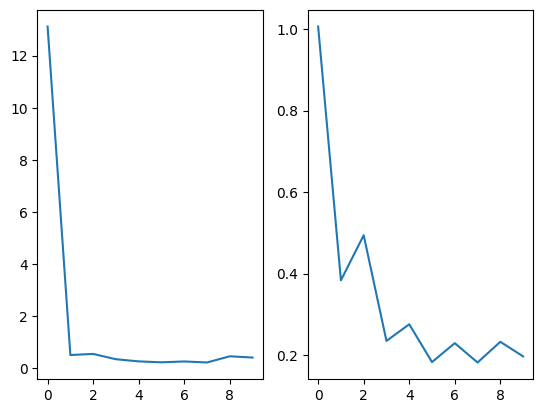

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(tr_losses1)
plt.subplot(1, 2, 2)
plt.plot(val_losses1)

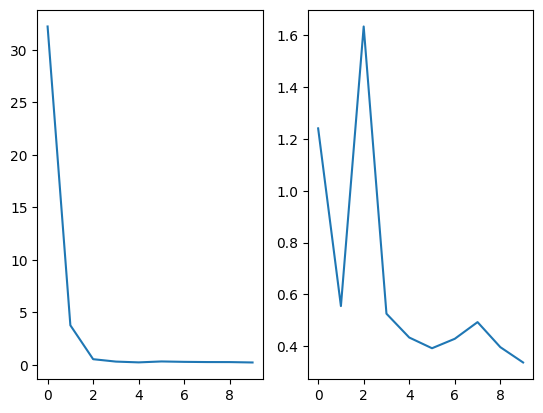

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(tr_losses2)
plt.subplot(1, 2, 2)
plt.plot(val_losses2)

## ORTOHOGONAL ALIGNMENT

**Introduzione al problema**

Nel paper "GIT RE-BASIN: MERGING MODELS MODULO PERMUTATION SYMMETRIES", definito $S_d$ l'insieme delle matrici di permutazione e definite $Z^{(A)} e Z^{(B)}$ come le matrici di attivazione rispettivamente per il modello A e B per un determinato layer $l$, viene risolto il problema

$P = \operatorname{argmin}_{P \in S_d} \sum_{i=1}^{n} || Z^{(A)}_{:, i} - PZ^{(B)}_{:, i}||^2$

Analogamente risolviamo

$Q = \operatorname{argmin}_{Q^TQ=1} \sum_{i=1}^{n} || Z^{(A)}_{:, i} - QZ^{(B)}_{:, i}||^2 = \operatorname{argmin}_{Q^TQ=1} || Z^{(A)} - QZ^{(B)}||^2_F$

in notazione matriciale, dove Q è una generica matrice ortogonale, ossia una matrice t.c. $Q^TQ = QQ^T = 1$.

Estendere l'idea alle matrici ortogonali significa ampliare le possibilità di applicazione perchè queste applicano rotazioni e riflessioni.

**Risoluzione del problema ai minimi quadrati**

(Per comodità di scrittura e leggibilita chiamo $Z^{(A)}$ come $A$ e $Z^{(B)}$ come $B$)

Iniziamo quindi da

$ Q = \operatorname{argmin}_{Q^TQ=1} || A - QB||^2_F$

Applicando il quadrato:

$Q = \operatorname{argmin}_{Q^TQ=1} ||A||^2_F + ||QB||^2_F - 2Tr(Q^TB^TA)$

Si puè ulteriormente semplificare notando che $||QB||^2_F = Tr(Q^TB^TBQ)=Tr(B^TB)$

Risulta quindi $Q = \operatorname{argmin}_{Q^TQ=1} ||A||^2_F + ||B||^2_F - 2Tr(Q^TB^TA)$

Notiamo allora che minimizzare questa quantità equivale a massimizzare $2Tr(Q^TB^TA)$, poichè è l'unico termine in cui compare Q ed è sottratto.

Sostituiamo $M = B^TA$ per poterci applicare SVD e otteniamo quindi
$Tr(Q^TM)=Tr(Q^TUΣV^T)=Tr(U^TQVΣ^T)$

Notando che $Σ = Σ^T$ e sostituendo per semplicità $R = U^TQV$ otteniamo $Tr(RΣ)$

Infine poichè R è ortogonale (prodotto di matrici ortogonali) le sue righe e colonne hanno norma 1 e quindi in particolare ogni elemento $|R_{ii}| <= 1$, allora, dato che Σ è diagonale a valori positivi, $Tr(RΣ)$ viene massimizzata per $R = I$ ($I$ è l'unica matrice ortogonale con diagonale unitaria). Da questo risuta che la soluzione al nostro problema è $Q = URV^T = UV^T$.


```
def Q_min_quadrati(A, B, alpha=False):
    M = B.T @ A          # dimensione: (d, d)
    U, _, Vt = torch.linalg.svd(M, full_matrices=False)
    Q = U @ Vt               # dimensione (d, d)
    return Q
```



In [ ]:
from src.orthogonal_alignment import Q_min_quadrati

**Matrici di attivazione**

Vediamo ora come computare le matrici di attivazione.

La matrice di attivazione di un determinato layer si costruisce a partire dai vettori di attivazione prodotti dal layer per ogni input, che contengono i valori di attivazione dei neuroni per l'input in questione. In particolare questi vettori constituiscono le righe della matrice di attivazione, che quindi ha dimensione (Numero di input, dimensione layer).

!: si utilizzano i valori di attivazione prima della ReLU, come viene fatto anche nel paper, per mantenere tutta le informazioni del layer e per una questione di stabilità (la ReLU potrebbe appiattire molti valori a zero, producendo una matrice sparsa che può dare problemi ad esempio con SVD)

```
def activation_matrix(model, dataloader, layer_num, device="cpu"):
    model.eval()
    activations_list = []
    with torch.no_grad():
      for batch in dataloader:
        x = batch["x"].to(device)
        x = x.to(device)
        for i, layer in enumerate(model.fc): #devo far passare l'input per tutti i layer fino a quello richiesto
          x = x.view(x.size(0), -1)
          x = layer(x)
          if i == layer_num:  #si ferma al layer richiesto
            break
        activations_list.append(x)
      A = torch.cat(activations_list, dim=0) #dimensioni: (N,d)
    return A
```

In [ ]:
from src.orthogonal_alignment import activation_matrix

**Applicazione di Q ai layer**

La seguente è la funzione per applicare le matrici ortogonali trovate ai layer del modello. In particolare per ogni layer calcoleremo $W = Q_iWQ_{i-1}^T$ e $b = Qb$, come fatto nel paper, poichè applicare $Q$ sia a destra che a sinistra garantisce che sia lo spazio degli input che quello degli output siano riallineati

```
def apply_Q(model, Q_dict):
    al_model = copy.deepcopy(model)
    prev_Q = None

    for i, layer in enumerate(al_model.fc):
      if isinstance(layer, torch.nn.Linear): #applico ai layer linear
        Q_curr = Q_dict[f"fc{i+1}"].to(layer.weight.device)
        W = layer.weight.data
        b = layer.bias.data if layer.bias is not None else None

        if prev_Q is None:
          W_al= Q_curr @ W
        else:
          W_al = Q_curr @ W @ prev_Q.T
        b_al =  Q_curr @ b if b is not None else None

        #Aggiornamento dei layer
        layer.weight.data = W_al
        layer.bias.data = b_al

        prev_Q = Q_curr

    return al_model

```

In [ ]:
from src.orthogonal_alignment import apply_Q

La funzione *apply_Q*, però, applica al modello delle matrici Q già calcolate in precedenza, senza tenere quindi conto dell’**interazione tra i diversi layer**.

Per ottimizzare l'allineamento ho deciso di utilizzare invece seguente funzione *apply_Q_layerwise*. Questa funzione infatti stima la matrice Q per ogni layer linear e poi aggiorna i pesi e i bias considerando anche le trasformazioni precedenti, in questo modo garantisce un allineamento migliore


```
def apply_Q_layerwise(model1, model2, train_dataloader1, train_dataloader2, alpha=0.7, m=True):
    if m:
      m1 = model1
      al_model = copy.deepcopy(model2)
    else:
      m1 = model2
      al_model = copy.deepcopy(model1)

    # prendo un batch per il forward
    x = next(iter(train_dataloader2))["x"].float()
    prev_Q = None

    for i, layer in enumerate(al_model.fc):
      if isinstance(layer, torch.nn.Linear): #applico ai layer linear
        A, B = activation_matrix(m1, train_dataloader1, i), activation_matrix(al_model, train_dataloader2, i)
        Q = Q_min_quadrati(A, B).to(layer.weight.device)
        if prev_Q is None:
          layer.weight.data = alpha * (Q @ layer.weight.data) + (1 - alpha) * layer.weight.data
        else:
          layer.weight.data = alpha * (Q @ layer.weight.data  @ prev_Q.T) + (1 - alpha) * layer.weight.data
        if layer.bias.data is not None:
          layer.bias.data = alpha * (Q @ layer.bias.data) + (1 - alpha) * layer.bias.data
        prev_Q = Q

        diff = torch.norm(A - B @ Q, 'fro')
        ortho_err = torch.norm(Q.T @ Q - torch.eye(Q.shape[0], device=Q.device)).item()
        det = torch.det(Q).item()
        #print(f'Layer {i} matching error: {diff.item()}')
        #print(f"Layer {i} ortho_err: {ortho_err:.2e} -> Q is orthogonal: {torch.allclose(Q.T @ Q, torch.eye(Q.shape[0]), atol=1e-5)}")
      x = layer(x)

    return al_model
```

In [ ]:
from src.orthogonal_alignment import apply_Q_layerwise

##Allineamento

In [ ]:
from src.test import evaluate_model

In [ ]:
al_model_layerwise2, Q_dict2 = apply_Q_layerwise(model1, model2, train_dataloader1, train_dataloader2, 0.8, m = True)

In [ ]:
evaluate_model(al_model_layerwise2, test_dataloader)

0.5396559238433838

In [ ]:
al_model_layerwise1, Q_dict1 = apply_Q_layerwise(model1, model2, train_dataloader1, train_dataloader2, 0.8, m = False)

In [ ]:
evaluate_model(al_model_layerwise1, test_dataloader)

0.7360033988952637

##Re-basin

In [ ]:
!pip install rebasin

In [ ]:
from rebasin import PermutationCoordinateDescent, interpolation

al_model_perm2 = copy.deepcopy(model2) #creo una copia di model2 perchè l'allineamento dei pesi avverà in loco

batch = next(iter(train_dataloader2))
inputs = batch["x"].to("cpu").float()

pcd = PermutationCoordinateDescent(model1, al_model_perm2, inputs, device_a=device, device_b=device)
pcd.rebasin()

model1.to(device)
al_model_perm2.to(device)

al_model_perm1 = copy.deepcopy(model1)

batch = next(iter(train_dataloader1))
inputs = batch["x"].to("cpu").float()

pcd = PermutationCoordinateDescent(model2, al_model_perm1, inputs, device_a=device, device_b=device)
pcd.rebasin()

##Merge: LERP e SLERP

Per analizzare il comportamento dei modelli sull'interpolazione utilizzo:
- **lerp** e **slerp** (interpolazione lineare e sferica)

- **Funzioni di plotting e confronto delle loss**:  
  Queste funzioni generano dei grafici in cui viene confrontata l’interpolazione dei modelli prima e dopo l’allineamento dei pesi fatto con *apply_Q_layerwise* e calcolano  i valori di loss minima lungo l’interpolazione.


In [ ]:
from src.merge import lerp_models, slerp_models

In [ ]:
from src.test_merge import loss_vs_alpha_ort_al2, loss_vs_alpha_ort_al1

100%|██████████| 11/11 [00:01<00:00,  8.31it/s]


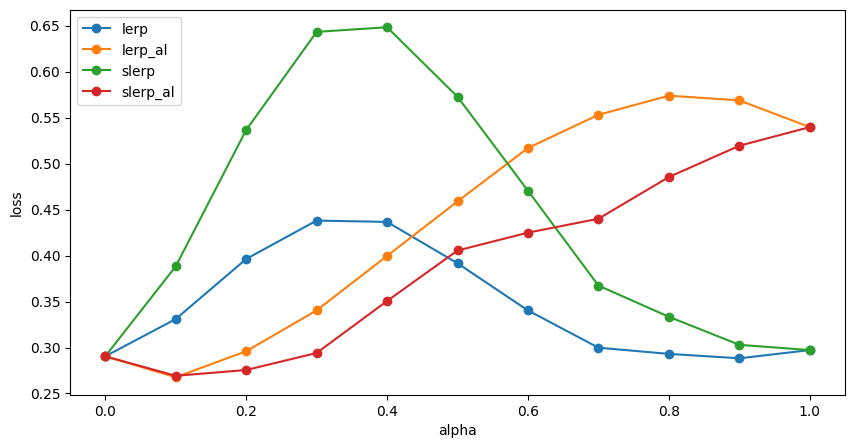

In [ ]:
lerp1, slerp1, allerp1, alslerp1 = loss_vs_alpha_ort_al1(model1, model2, al_model_layerwise1, test_dataloader)

100%|██████████| 11/11 [00:00<00:00, 11.49it/s]


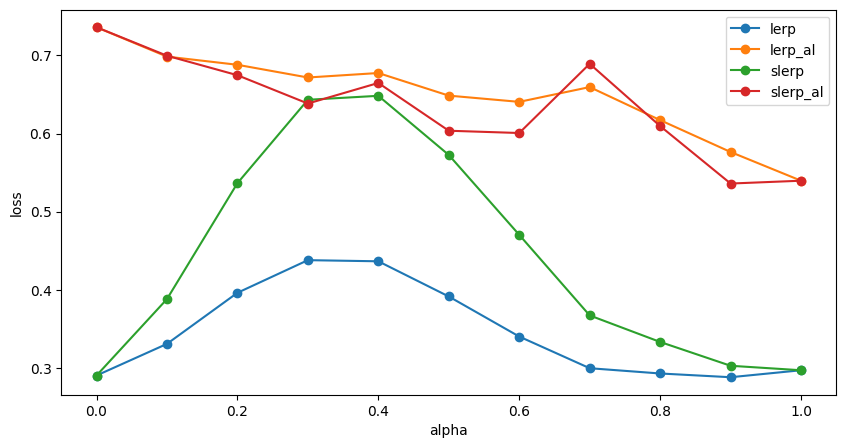

In [ ]:
lerp2, slerp2, allerp2, alslerp2 = loss_vs_alpha_ort_al2(model1, model2, al_model_layerwise2, test_dataloader)

In [ ]:
data = [
    ["LERP", allerp1[0], allerp2[0], lerp1[0], lerp2[0]],
    ["SLERP", alslerp1[0], alslerp2[0], slerp1[0], slerp2[0]]
]
headers = ["","modello_allinato1", "modello_allinato2", "modello1", "modello2"]

print(tabulate(data, headers=headers, tablefmt="grid"))

In [ ]:
from src.test_merge import loss_vs_alpha_withperm1, loss_vs_alpha_withperm2

100%|██████████| 11/11 [00:01<00:00,  5.65it/s]


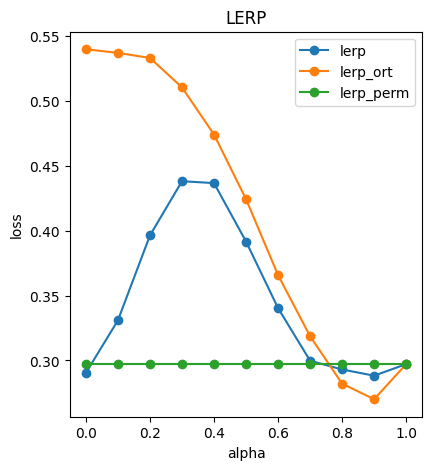

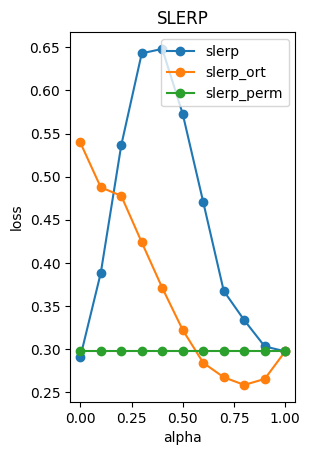

In [ ]:
lerp2, slerp2, allerp2, alslerp2, permlerp2, permslerp2 = loss_vs_alpha_withperm2(model1, model2, al_model_layerwise2, al_model_perm2, test_dataloader)

In [ ]:
lerp1, slerp1, allerp1, alslerp1, permlerp1, permslerp1 = loss_vs_alpha_withperm1(model1, model2, al_model_layerwise1, al_model_perm1, test_dataloader)


In [ ]:
data = [
    ["LERP", allerp1[0], permlerp1[0], allerp2[0], permlerp2[0], lerp1[0], slerp1[0]],
    ["SLERP", alslerp1[0], permslerp1[0], alslerp2[0], permslerp2[0], slerp1[0], slerp2[0]]
]
headers = ["","modello_ort_1", "modello_perm_1", "modello_ort_2", "modello_perm_2" , "modello1", "modello2"]

print(tabulate(data, headers=headers, tablefmt="grid"))

##Analisi non linearità

In [ ]:
from src.test import misalignment_ReLU

La funzione *misalignment_ReLU* misura, per ciascun layer lineare di due modelli, la differenza tra le attivazioni prima e dopo l’applicazione della ReLU tramite la norma di Fobenius

Input della funzione:
- modello 1
- modello allineato all'1
- train dataloader
- dizionario Q_dict delle matrici utilizzate per l'allineamento

In [ ]:
misalignment_ReLU(model1, al_model_layerwise1, train_dataloader1, Q_dict1)

Si nota che la ReLU migliora l'effetto dell'ortogonalizzazione nonostante la non-linearità, questo probabilmente perchè i valori target del nostro modello sono tutti positivi e la ReLU annulla i valori negativi trasformandoli in zeri

##Cycle-consistency

Calcolando la cycle consistency verifico se gli allineamenti fatti sono **reversibili** e **coerenti**.

In particolare:
- A -> B -> A: (funzione *cycle_consistency_ABA*) allineo A a B e poi il modello ottenuto di nuovo ad A, poi confronto i pesi finali con quelli di A per misurare quanto l'allineamento sia reversibile.

- A -> B -> C vs A -> C: (funzione *cycle_consistency_ABC*) allineo A a B e il modello ottenuto a C, poi allineo A (originale) a C e confronto i due modelli ottenuti; se sono simili vuol dire che l’allineamento tra più modelli è consistente.

In [ ]:
from src.test import cycle_consistency_ABA, cycle_consistency_ABC

In [ ]:
torch.manual_seed(5)
model3 = MLP_4().to(device)

optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=max_epochs)
loss_fn = nn.CrossEntropyLoss()
val_losses3 = []
tr_losses3 = []
epochs = max_epochs


train_loop(train_val3[0], train_val3[1], model3, loss_fn, optimizer2, epochs, tr_losses2, val_losses2)

In [ ]:
cycle_consistency_ABA(model1, model2, train_dataloader1, train_dataloader2)

In [ ]:
cycle_consistency_ABC(model1, model2, model3, train_dataloader1, train_dataloader2, train_val3[0])